# Figures

## Import packages.

In [1]:
import graphviz as gv
import numpy    as np
import pandas   as pd
import re       as re
import seaborn  as sb

from sklearn                 import svm
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LinearRegression, LogisticRegression
from sklearn.metrics         import confusion_matrix, explained_variance_score, make_scorer
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.neural_network  import MLPClassifier, MLPRegressor
from sklearn.preprocessing   import MinMaxScaler
from sklearn.tree            import DecisionTreeClassifier

from IPython.display import display

## Descriptive plots.

### Define nonlinear scales.

In [11]:
import matplotlib.scale      as mscale
import matplotlib.pyplot     as plt
import matplotlib.transforms as mtransforms
import matplotlib.ticker     as ticker

class SquareRootScale(mscale.ScaleBase):

    name = 'squareroot'

    def __init__(self, axis, **kwargs):
        mscale.ScaleBase.__init__(self, axis)

    def set_default_locators_and_formatters(self, axis):
        axis.set_major_locator(ticker.AutoLocator())
        axis.set_major_formatter(ticker.ScalarFormatter())
        axis.set_minor_locator(ticker.NullLocator())
        axis.set_minor_formatter(ticker.NullFormatter())

    def limit_range_for_scale(self, vmin, vmax, minpos):
        return  max(0., vmin), vmax

    class SquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def transform_non_affine(self, a): 
            return np.array(a)**0.5

        def inverted(self):
            return SquareRootScale.InvertedSquareRootTransform()

    class InvertedSquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def transform(self, a):
            return np.array(a)**2

        def inverted(self):
            return SquareRootScale.SquareRootTransform()

    def get_transform(self):
        return self.SquareRootTransform()

mscale.register_scale(SquareRootScale)


class ArctangentScale(mscale.ScaleBase):
    name = 'arctangent'

    def __init__(self, axis, **kwargs):
        mscale.ScaleBase.__init__(self, axis)

    def set_default_locators_and_formatters(self, axis):
        axis.set_major_locator(ticker.AutoLocator())
        axis.set_major_formatter(ticker.ScalarFormatter())
        axis.set_minor_locator(ticker.NullLocator())
        axis.set_minor_formatter(ticker.NullFormatter())

    def limit_range_for_scale(self, vmin, vmax, minpos):
        return vmin, vmax

    class ArctangentTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def transform_non_affine(self, a): 
            return np.arctan(np.array(a)) * 2 / np.pi

        def inverted(self):
            return ArctangentScale.InvertedArctangentTransform()

    class InvertedArctangentTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def transform(self, a):
            return np.tan(np.array(a) * np.pi / 2)

        def inverted(self):
            return ArctangentScale.ArctangentTransform()

    def get_transform(self):
        return self.ArctangentTransform()

mscale.register_scale(ArctangentScale)

### Load data.

In [2]:
z = pd.read_csv(
    "results-20200725.tsv",
    sep = "\t",
).drop_duplicates(
    ["Devices", "Outages"]
).drop(
    columns = ["Folder", "Case", "Outages"]
).reset_index(drop = True)
z = z[~np.isnan(z["Unserved MW"])]

z["Reactance Bottleneck 0 atan" ] = np.arctan(z["Reactance Bottleneck 0"])
z["Reactance Bottleneck 1 atan" ] = np.arctan(z["Reactance Bottleneck 1"])
z["Capacity Bottleneck 0 atan"  ] = np.arctan(z["Capacity Bottleneck 0" ])
z["Capacity Bottleneck 1 atan"  ] = np.arctan(z["Capacity Bottleneck 1" ])
z["Flow Bottleneck 0 atan"      ] = np.arctan(z["Flow Bottleneck 0"])
z["Flow Bottleneck 1 atan"      ] = np.arctan(z["Flow Bottleneck 1"])
z["Residue Bottleneck 0 atan"   ] = np.arctan(z["Residue Bottleneck 0"  ])
z["Residue Bottleneck 1 atan"   ] = np.arctan(z["Residue Bottleneck 1"  ])
z["Unweighted Bottleneck 0 atan"] = np.arctan(z["Unweighted Bottleneck 0"])
z["Unweighted Bottleneck 1 atan"] = np.arctan(z["Unweighted Bottleneck 1"])

z["Involves Line"       ] = z["Devices"] != "Transformer2W"
z["Involves Transformer"] = z["Devices"] != "Line"

z["Has Unserved"] = z["Unserved MW"] > 0

In [3]:
z.columns

Index(['Devices', 'Radius', 'Fraction', 'Outage Count', 'Outage Fraction',
       'Served MW', 'Unserved MW', 'Unserved Fraction', 'Reactance Loss pu',
       'Reactance Betti 0', 'Reactance Betti 1', 'Reactance Bottleneck 0',
       'Reactance Bottleneck 1', 'Capacity Loss MW', 'Capacity Betti 0',
       'Capacity Betti 1', 'Capacity Bottleneck 0', 'Capacity Bottleneck 1',
       'Flow Loss MW', 'Flow Betti 0', 'Flow Betti 1', 'Flow Bottleneck 0',
       'Flow Bottleneck 1', 'Residue Loss MW', 'Residue Betti 0',
       'Residue Betti 1', 'Residue Bottleneck 0', 'Residue Bottleneck 1',
       'Unweighted Loss', 'Unweighted Betti 0', 'Unweighted Betti 1',
       'Unweighted Bottleneck 0', 'Unweighted Bottleneck 1',
       'Reactance Bottleneck 0 atan', 'Reactance Bottleneck 1 atan',
       'Capacity Bottleneck 0 atan', 'Capacity Bottleneck 1 atan',
       'Flow Bottleneck 0 atan', 'Flow Bottleneck 1 atan',
       'Residue Bottleneck 0 atan', 'Residue Bottleneck 1 atan',
       'Unweight

In [4]:
z.describe()

,Radius,Fraction,Outage Count,Outage Fraction,Served MW,Unserved MW,Unserved Fraction,Reactance Loss pu,Reactance Betti 0,Reactance Betti 1,...,Reactance Bottleneck 0 atan,Reactance Bottleneck 1 atan,Capacity Bottleneck 0 atan,Capacity Bottleneck 1 atan,Flow Bottleneck 0 atan,Flow Bottleneck 1 atan,Residue Bottleneck 0 atan,Residue Bottleneck 1 atan,Unweighted Bottleneck 0 atan,Unweighted Bottleneck 1 atan
count,124372.000000,124372.000000,124372.000000,124372.000000,124372.000000,124372.000000,124372.000000,124372.000000,124372.000000,124372.000000,...,1.243720e+05,124372.000000,1.243720e+05,124372.000000,1.243720e+05,124372.000000,1.243720e+05,124372.000000,1.243720e+05,124372.000000
mean,11.596621,10.227447,50.036383,0.021405,66919.668270,189.566730,0.002825,1.889020,1.461535,624.147276,...,3.089042e-01,1.516041,3.059599e-01,1.516034,4.587214e-01,1.516035,3.231925e-01,1.515706,3.672162e-01,1.516033
std,7.757323,18.081003,67.838297,0.028891,612.787765,612.787765,0.009131,2.644888,1.376526,42.776667,...,6.203157e-01,0.288099,6.217333e-01,0.288136,6.462432e-01,0.288128,6.325806e-01,0.288966,6.114303e-01,0.288137
min,0.000000,0.000000,0.000000,0.000000,52836.381978,0.000000,0.000000,0.000000,1.000000,331.000000,...,9.885838e-309,0.000000,1.834760e-308,0.000000,1.661023e-308,0.000000,2.212295e-308,0.000000,1.263560e-308,0.000000
25%,5.000000,2.000000,6.000000,0.002559,67026.106986,0.000000,0.000000,0.200630,1.000000,619.000000,...,6.499999e-04,1.570796,2.126528e-04,1.570796,1.160011e-03,1.570796,1.110340e-04,1.570796,1.263560e-308,1.570796
50%,10.000000,5.000000,24.000000,0.010235,67109.235000,0.000000,0.000000,0.849290,1.000000,641.000000,...,3.859981e-03,1.570796,3.623188e-04,1.570796,2.026749e-02,1.570796,4.930127e-04,1.570796,1.263560e-308,1.570796
75%,20.000000,10.000000,59.000000,0.025160,67109.235000,83.128014,0.001239,2.160520,1.000000,652.000000,...,1.172946e-02,1.570796,9.368078e-04,1.570796,1.235355e+00,1.570796,4.623865e-03,1.570796,4.636476e-01,1.570796
max,25.000000,100.000000,581.000000,0.247761,67109.235000,14272.853022,0.212681,20.893220,27.000000,656.000000,...,1.570796e+00,1.570796,1.570796e+00,1.570796,1.570796e+00,1.570796,1.570796e+00,1.570796,1.570796e+00,1.570796


### Pairs plots.

In [5]:
def pairplot(base, loss0, loss1, file):
    g = sb.pairplot(
        data = z.rename(columns = {
            "Outage_Fraction"           : "Outage Fraction"    ,
            "Unserved_Fraction"         : "Unserved Fraction"  ,
            loss0                       : loss1                ,
            base + "_Betti_0"           : "Betti 0"            ,
            base + "_Betti_1"           : "Betti 1"            ,
            base + "_Bottleneck_0_atan" : "atan(Bottleneck 0)" ,
            base + "_Bottleneck_1_atan" : "atan(Bottleneck 1)" ,
        }),
        vars = [
            "Outage Fraction"    ,
            "Unserved Fraction"  ,
            loss1                ,
            "Betti 0"            ,
            "Betti 1"            ,
            "atan(Bottleneck 0)" ,
            "atan(Bottleneck 1)" ,
        ],
        hue = "Devices",
        plot_kws = {
            "s"         : 15    ,
            "alpha"     : 0.1   ,
            "edgecolor" : "none",
        },
    )
#   for i in range(5):
#       g.axes[    i, 0    ].set_yscale("squareroot")
#       g.axes[0    ,     i].set_xscale("squareroot")
#   for i in range(2):
#       g.axes[5 + i, 0    ].set_yscale("arctangent")
#       g.axes[6    , 4 + i].set_xscale("arctangent")
    for lh in g._legend.legendHandles: 
        lh.set_alpha(1)
        lh._sizes = [50]
#   g.fig.set_figwidth(9)
#   g.fig.set_figheight(4.5)
#   g.savefig(file, dpi = 300)#, bbox_inches='tight')
#   g.savefig(file, dpi = 300)#, bbox_inches='tight')
    return g

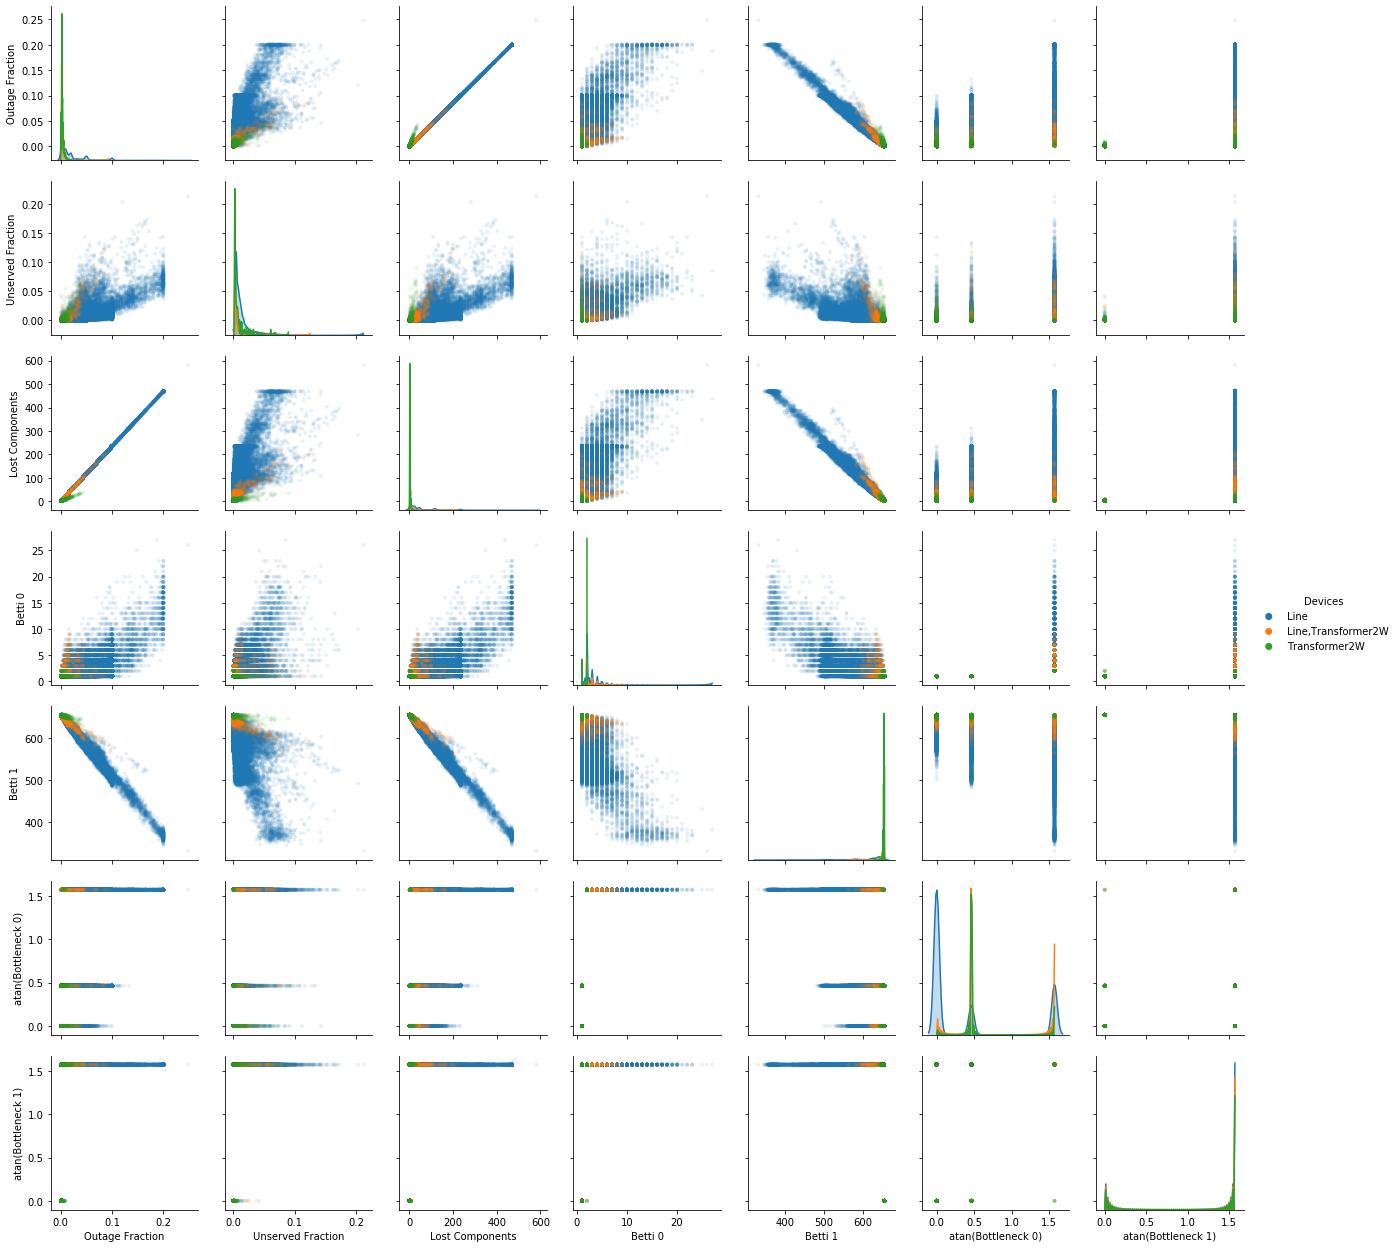

In [21]:
pairplot("Unweighted", "Unweighted_Loss", "Lost Components", None)

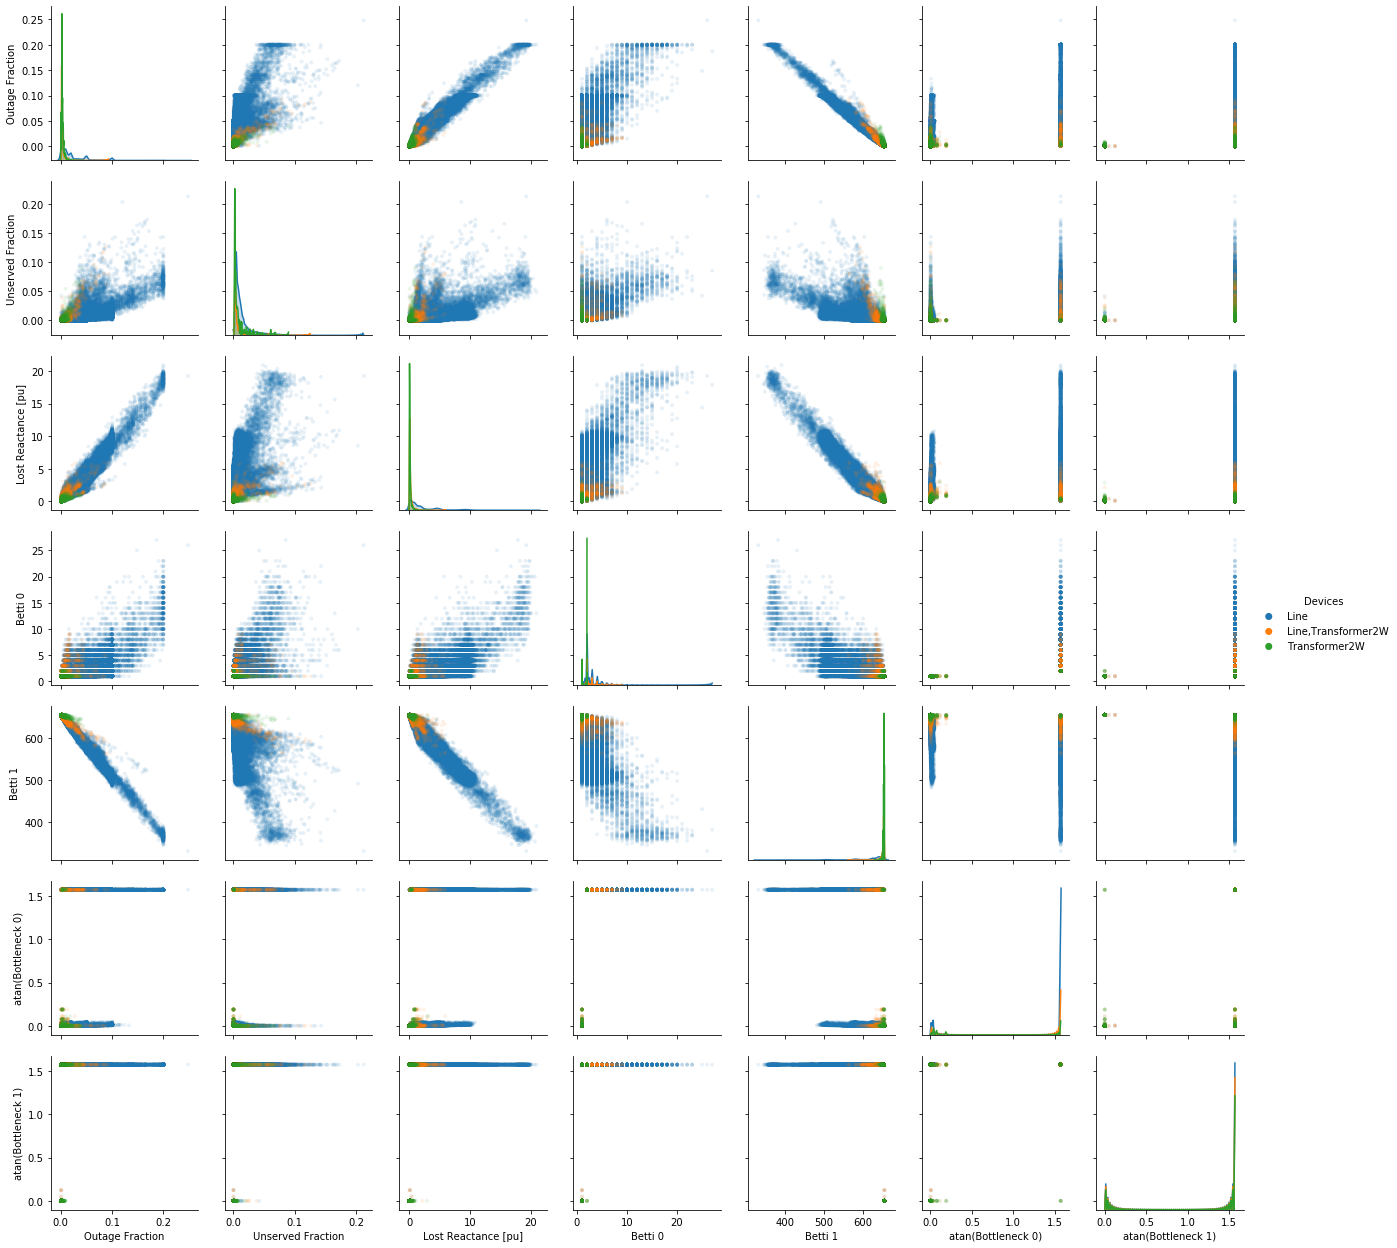

In [24]:
pairplot("Reactance", "Reactance_Loss_pu", "Lost Reactance [pu]", None)

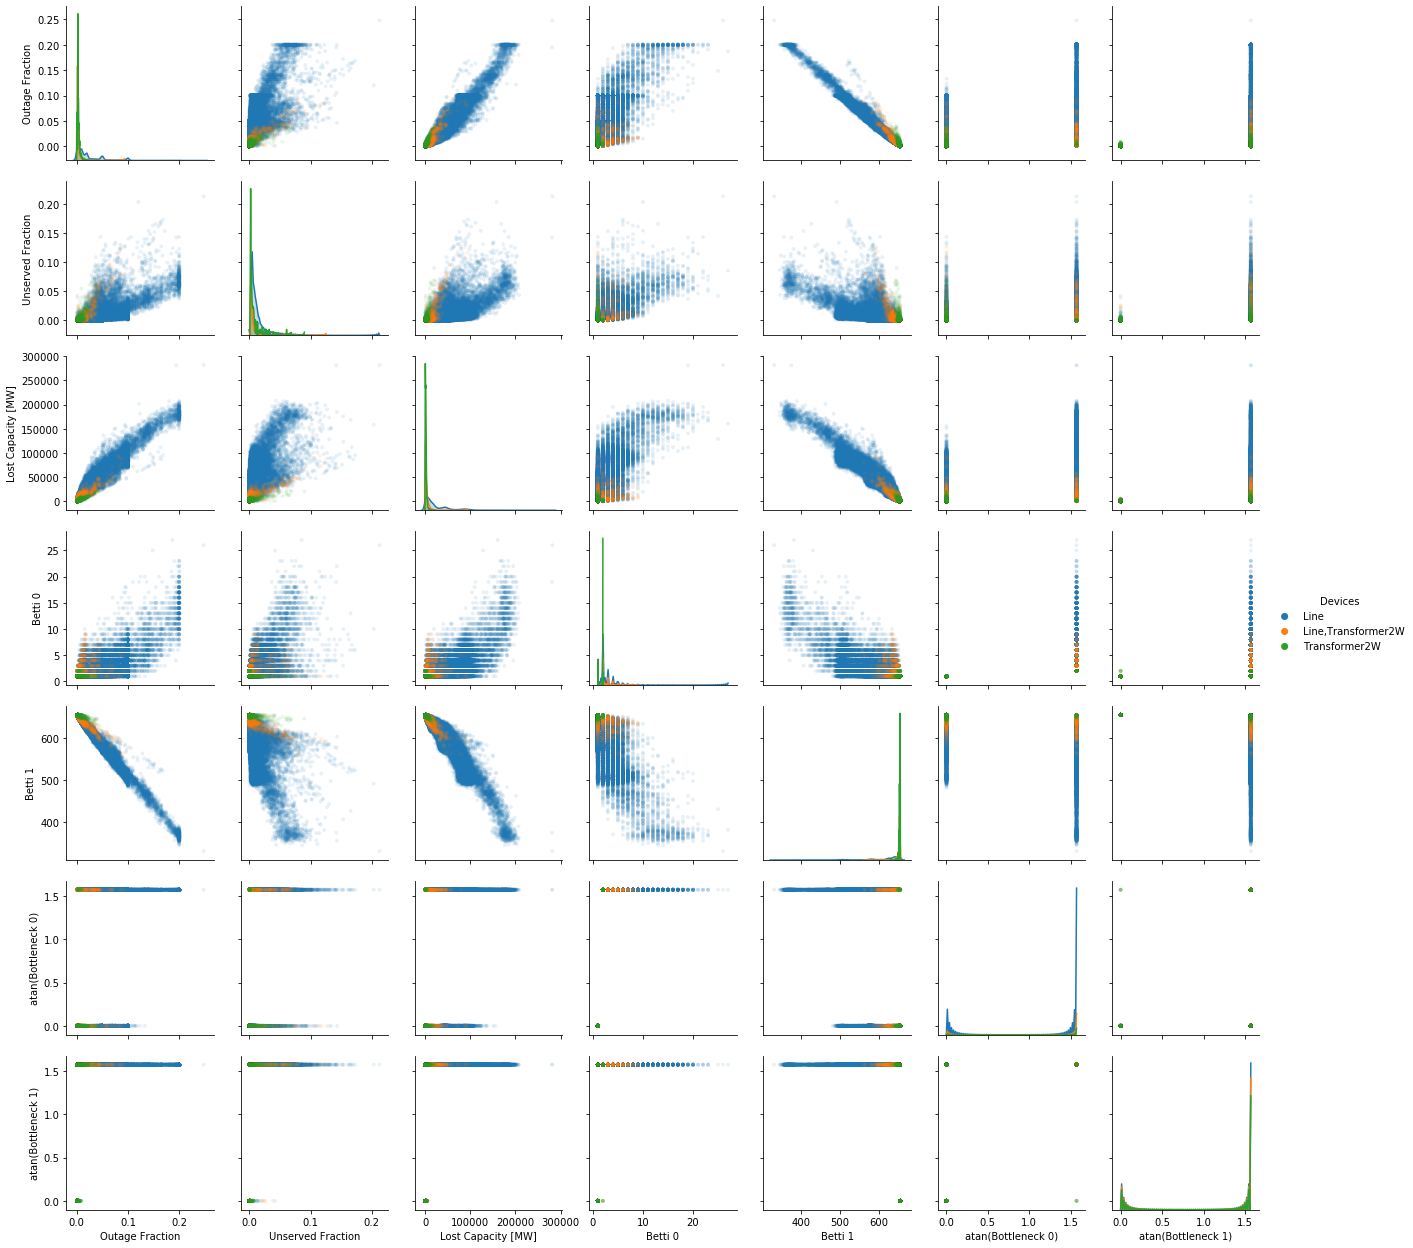

In [25]:
pairplot("Capacity", "Capacity_Loss_MW", "Lost Capacity [MW]", None)

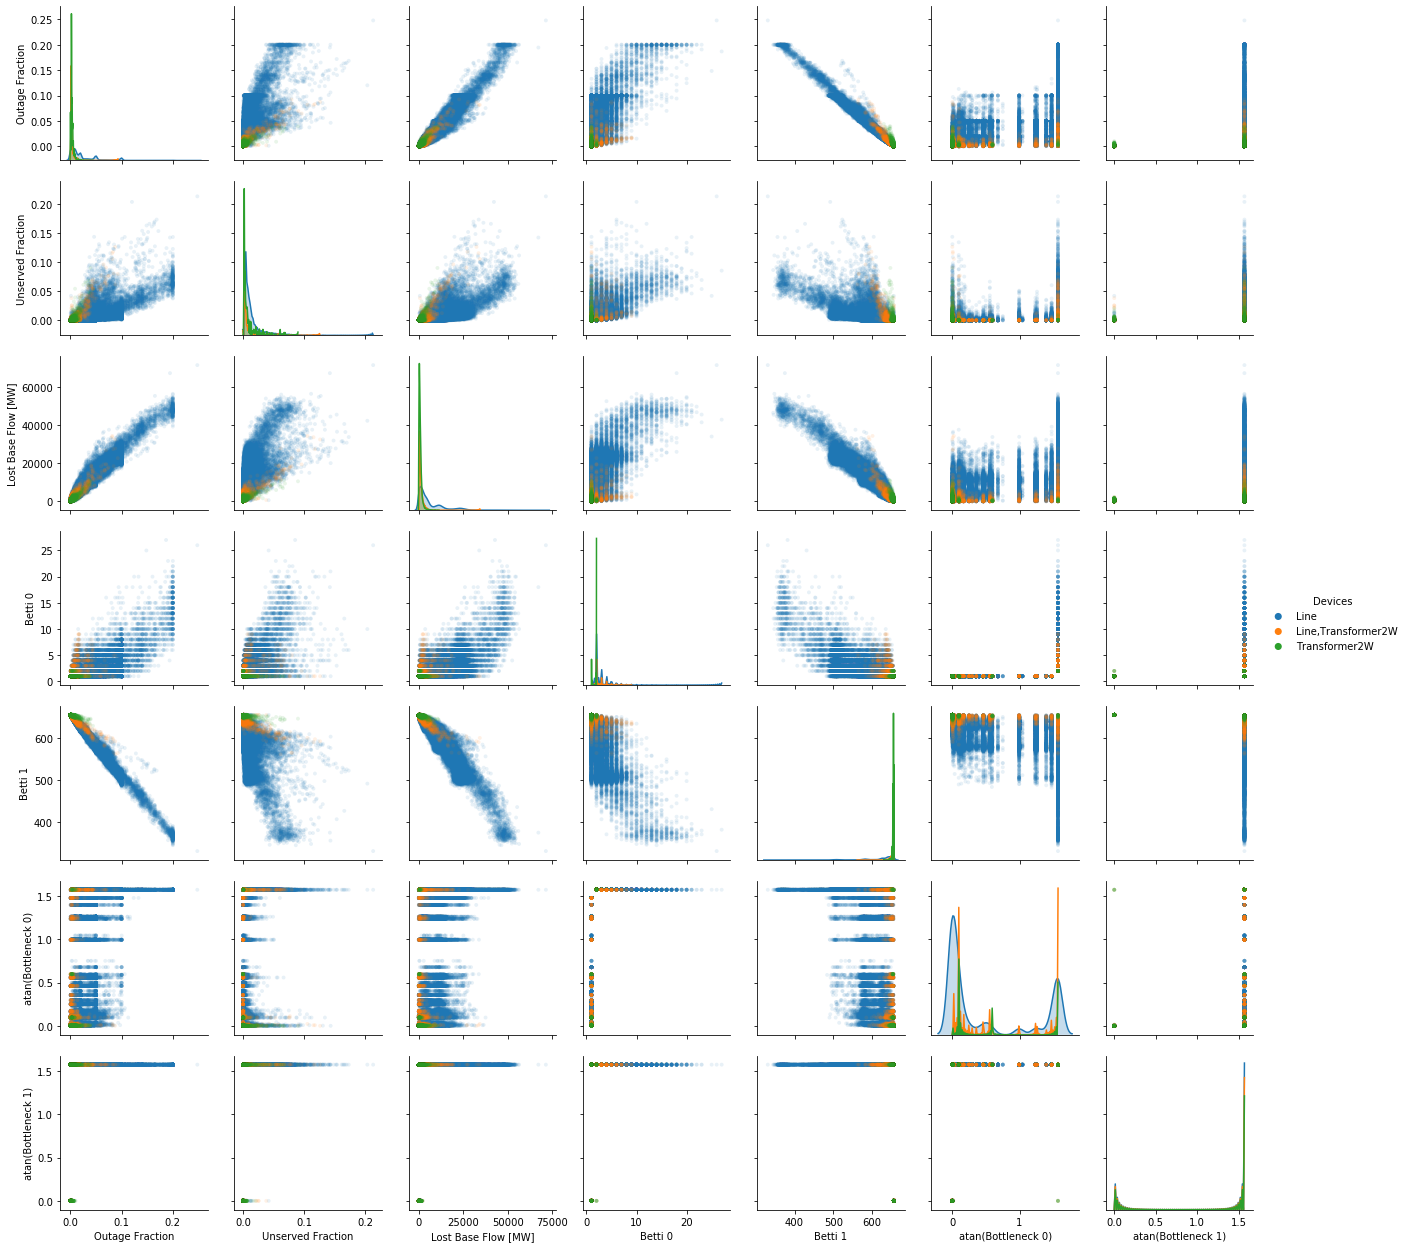

In [26]:
pairplot("Base_Flow", "Base_Flow_Loss_MW", "Lost Base Flow [MW]", None)

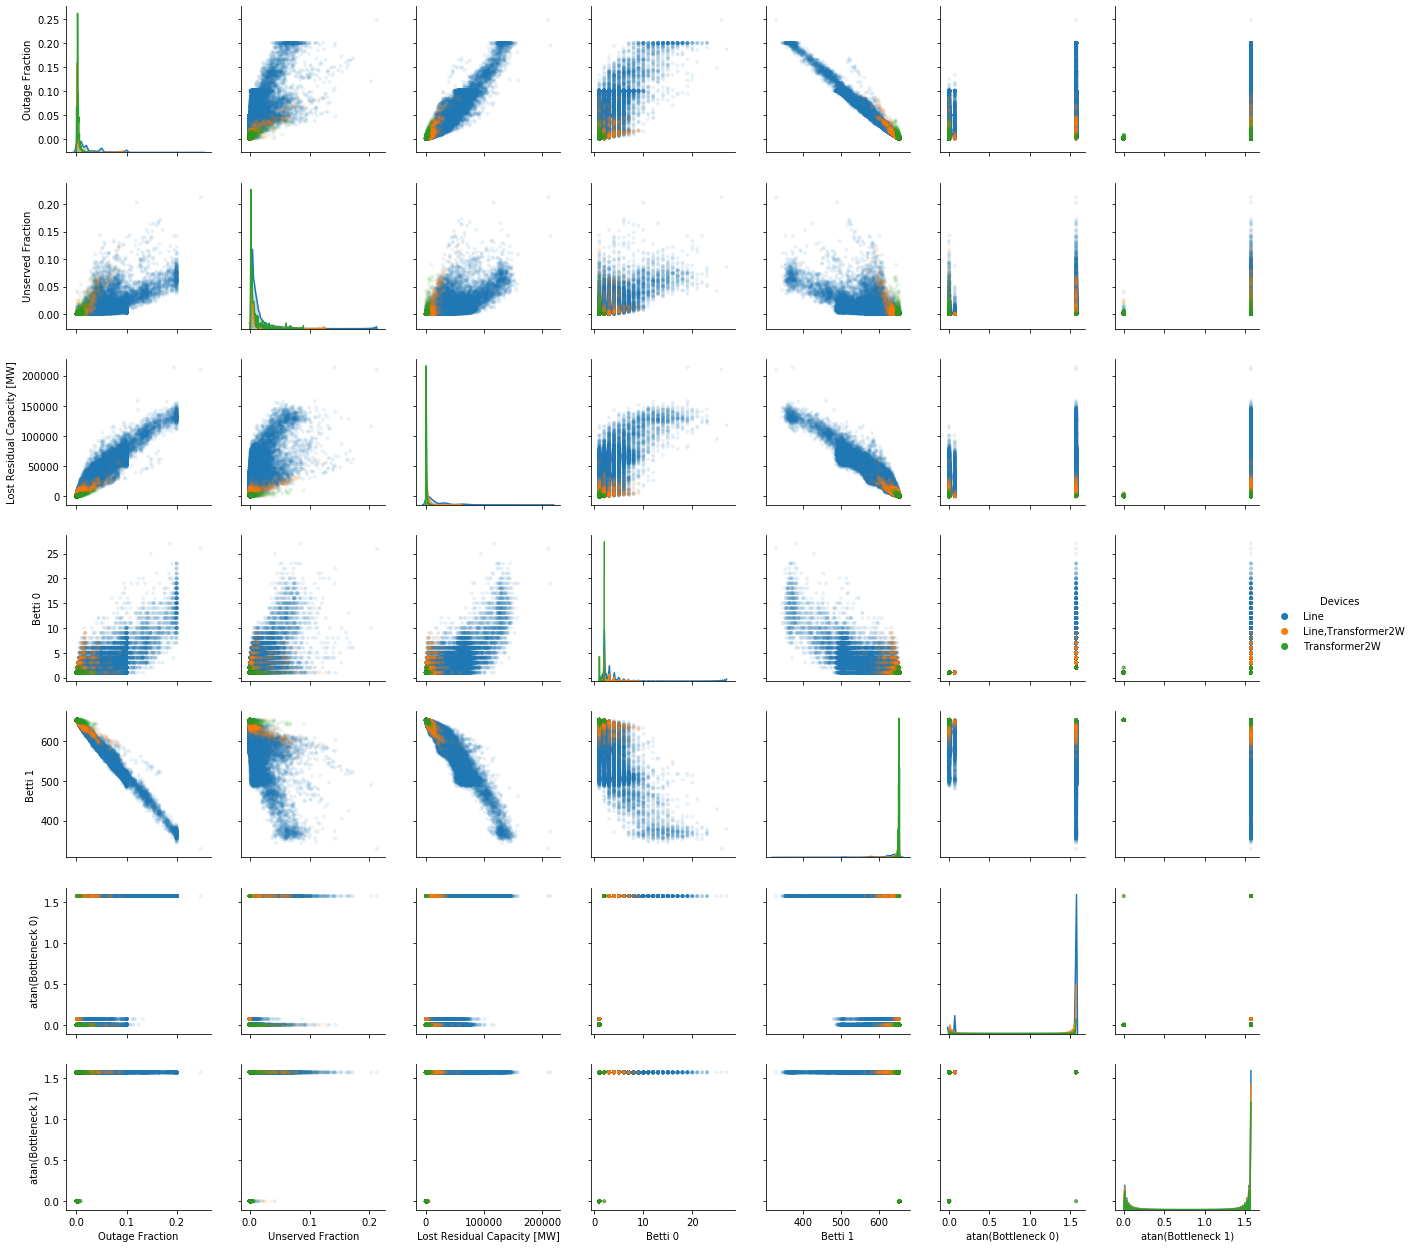

In [27]:
pairplot("Residue", "Residue_Loss_MW", "Lost Residual Capacity [MW]", None)

## Fits.

### Sets of factors.

In [5]:
sets = [
    [                     "Unweighted Betti 0", "Unweighted Betti 1", "Unweighted Bottleneck 0 atan", "Unweighted Bottleneck 1 atan"],
    ["Unweighted Loss"  , "Unweighted Betti 0", "Unweighted Betti 1", "Unweighted Bottleneck 0 atan", "Unweighted Bottleneck 1 atan"],
    [                     "Reactance Betti 0" , "Reactance Betti 1" , "Reactance Bottleneck 0 atan" , "Reactance Bottleneck 1 atan" ],
    ["Reactance Loss pu", "Reactance Betti 0" , "Reactance Betti 1" , "Reactance Bottleneck 0 atan" , "Reactance Bottleneck 1 atan" ],
    [                     "Capacity Betti 0"  , "Capacity Betti 1"  , "Capacity Bottleneck 0 atan"  , "Capacity Bottleneck 1 atan"  ],
    ["Capacity Loss MW" , "Capacity Betti 0"  , "Capacity Betti 1"  , "Capacity Bottleneck 0 atan"  , "Capacity Bottleneck 1 atan"  ],
    [                     "Reactance Betti 0" , "Reactance Betti 1" , "Reactance Bottleneck 0 atan" , "Reactance Bottleneck 1 atan" ],
    ["Reactance Loss pu", "Reactance Betti 0" , "Reactance Betti 1" , "Reactance Bottleneck 0 atan" , "Reactance Bottleneck 1 atan" ],
    [                     "Residue Betti 0"   , "Residue Betti 1"   , "Residue Bottleneck 0 atan"   , "Residue Bottleneck 1 atan"   ],
    ["Residue Loss MW"  , "Residue Betti 0"   , "Residue Betti 1"   , "Residue Bottleneck 0 atan"   , "Residue Bottleneck 1 atan"   ],
]
suffixes = [
    [],
    ["Involves Line", "Involves Transformer"],
    ["Radius", "Fraction"],
    ["Outage Fraction"],
    ["Radius", "Fraction", "Outage Fraction"],
    ["Involves Line", "Involves Transformer", "Radius", "Fraction"],
    ["Involves Line", "Involves Transformer", "Outage Fraction"],
    ["Involves Line", "Involves Transformer", "Radius", "Fraction", "Outage Fraction"],
]
trials = [
    set + suffix
    for suffix in suffixes
    for set    in sets
]
len(trials)

80

### Training and testing sets.

In [6]:
z_sample = (z.copy() if True else z.sample(20000)).drop(columns = [
    'Devices'                , 'Outage Count'           ,
    'Served MW'              , 'Unserved Fraction'      ,
    'Reactance Bottleneck 0' , 'Reactance Bottleneck 1' ,
    'Capacity Bottleneck 0'  , 'Capacity Bottleneck 1'  , 
    'Flow Bottleneck 0'      , 'Flow Bottleneck 1'      ,
    'Residue Bottleneck 0'   , 'Residue Bottleneck 1'   ,
    'Unweighted Bottleneck 0', 'Unweighted Bottleneck 1',
])

z_sample = pd.DataFrame(
    MinMaxScaler().fit_transform(z_sample.values),
    columns=z_sample.columns,
    index=z_sample.index,
)
X = z_sample
y = z_sample[["Has Unserved", "Unserved MW"]]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size   = 0.3,
    random_state= 0  ,
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((87060, 32), (37312, 32), (87060, 2), (37312, 2))

### Classification.

In [8]:
def classify(
    name                    ,
    model                   ,
    X_train = X_train       ,
    y_train = y_train       ,
    X_test  = X_test        ,
    y_test  = y_test        ,
    trials  = trials        ,
    metric  = "Has Unserved",
    verbose = False         ,
):
    results = None
    for trial in trials:
        if verbose:
            print(trial)
        fit = model.fit(X_train[trial], y_train[metric])
        score = fit.score(X_test[trial], y_test[metric])
        confusion = confusion_matrix(y_test[metric], model.predict(X_test[trial]))
        confusion = confusion / confusion.sum()
        results = pd.DataFrame({
            "Model"           : [name]                                         ,
            "Weighting"       : re.sub(r" .*$", "", trial[0])                  ,
            "Devices"         : any(["Involves" in factor for factor in trial]),
            "Loss"            : any(["Loss"     in factor for factor in trial]),
            "Radius"          : "Radius"          in trial                     ,
            "Fraction"        : "Fraction"        in trial                     ,
            "Outage Fraction" : "Outage Fraction" in trial                     ,
            "Score"           : score                                          ,
            "True Positive"   : confusion[1,1]                                 ,
            "True Negative"   : confusion[0,0]                                 ,
            "False Positive"  : confusion[0,1]                                 ,
            "False Negative"  : confusion[1,0]                                 ,
        }).append(results)
    return results.reset_index(drop = True)

#### Linear SVM.

In [9]:
class_linsvm = classify(
    "Linear SVM",
    svm.SVC(
        kernel   = "linear",
#       max_iter = 1000000 ,
    ),
    verbose = True,
)
class_linsvm

['Unweighted Betti 0', 'Unweighted Betti 1', 'Unweighted Bottleneck 0 atan', 'Unweighted Bottleneck 1 atan']
['Unweighted Loss', 'Unweighted Betti 0', 'Unweighted Betti 1', 'Unweighted Bottleneck 0 atan', 'Unweighted Bottleneck 1 atan']
['Reactance Betti 0', 'Reactance Betti 1', 'Reactance Bottleneck 0 atan', 'Reactance Bottleneck 1 atan']
['Reactance Loss pu', 'Reactance Betti 0', 'Reactance Betti 1', 'Reactance Bottleneck 0 atan', 'Reactance Bottleneck 1 atan']
['Capacity Betti 0', 'Capacity Betti 1', 'Capacity Bottleneck 0 atan', 'Capacity Bottleneck 1 atan']
['Capacity Loss MW', 'Capacity Betti 0', 'Capacity Betti 1', 'Capacity Bottleneck 0 atan', 'Capacity Bottleneck 1 atan']
['Reactance Betti 0', 'Reactance Betti 1', 'Reactance Bottleneck 0 atan', 'Reactance Bottleneck 1 atan']
['Reactance Loss pu', 'Reactance Betti 0', 'Reactance Betti 1', 'Reactance Bottleneck 0 atan', 'Reactance Bottleneck 1 atan']
['Residue Betti 0', 'Residue Betti 1', 'Residue Bottleneck 0 atan', 'Residue Bo

['Residue Betti 0', 'Residue Betti 1', 'Residue Bottleneck 0 atan', 'Residue Bottleneck 1 atan', 'Involves Line', 'Involves Transformer', 'Radius', 'Fraction']
['Residue Loss MW', 'Residue Betti 0', 'Residue Betti 1', 'Residue Bottleneck 0 atan', 'Residue Bottleneck 1 atan', 'Involves Line', 'Involves Transformer', 'Radius', 'Fraction']
['Unweighted Betti 0', 'Unweighted Betti 1', 'Unweighted Bottleneck 0 atan', 'Unweighted Bottleneck 1 atan', 'Involves Line', 'Involves Transformer', 'Outage Fraction']
['Unweighted Loss', 'Unweighted Betti 0', 'Unweighted Betti 1', 'Unweighted Bottleneck 0 atan', 'Unweighted Bottleneck 1 atan', 'Involves Line', 'Involves Transformer', 'Outage Fraction']
['Reactance Betti 0', 'Reactance Betti 1', 'Reactance Bottleneck 0 atan', 'Reactance Bottleneck 1 atan', 'Involves Line', 'Involves Transformer', 'Outage Fraction']
['Reactance Loss pu', 'Reactance Betti 0', 'Reactance Betti 1', 'Reactance Bottleneck 0 atan', 'Reactance Bottleneck 1 atan', 'Involves Lin

,Model,Weighting,Devices,Loss,Radius,Fraction,Outage Fraction,Score,True Positive,True Negative,False Positive,False Negative
0,Linear SVM,Residue,True,True,True,True,True,0.844715,0.321505,0.523210,0.023826,0.131459
1,Linear SVM,Residue,True,False,True,True,True,0.845197,0.321666,0.523531,0.023505,0.131298
2,Linear SVM,Reactance,True,True,True,True,True,0.846350,0.320326,0.526024,0.021012,0.132638
3,Linear SVM,Reactance,True,False,True,True,True,0.846377,0.320353,0.526024,0.021012,0.132611
4,Linear SVM,Capacity,True,True,True,True,True,0.845653,0.320138,0.525515,0.021521,0.132826
...,...,...,...,...,...,...,...,...,...,...,...,...
75,Linear SVM,Capacity,False,False,False,False,False,0.820674,0.288245,0.532429,0.014607,0.164719
76,Linear SVM,Reactance,False,True,False,False,False,0.820701,0.288567,0.532134,0.014901,0.164398
77,Linear SVM,Reactance,False,False,False,False,False,0.820701,0.288567,0.532134,0.014901,0.164398
78,Linear SVM,Unweighted,False,True,False,False,False,0.871543,0.340346,0.531196,0.015839,0.112618


In [10]:
class_linsvm.Score.max()

0.8752948113207547

#### RDF SVM.

In [11]:
class_rbfsvm = classify(
    "RBF SVM",
    svm.SVC(
        kernel   = "rbf"  ,
        gamma    = "auto" ,
#       max_iter = 1000000,
    ),
)
class_rbfsvm

,Model,Weighting,Devices,Loss,Radius,Fraction,Outage Fraction,Score,True Positive,True Negative,False Positive,False Negative
0,RBF SVM,Residue,True,True,True,True,True,0.841954,0.317726,0.524228,0.022808,0.135238
1,RBF SVM,Residue,True,False,True,True,True,0.841981,0.316869,0.525113,0.021923,0.136096
2,RBF SVM,Reactance,True,True,True,True,True,0.842678,0.314832,0.527846,0.019190,0.138133
3,RBF SVM,Reactance,True,False,True,True,True,0.843160,0.315395,0.527766,0.019270,0.137570
4,RBF SVM,Capacity,True,True,True,True,True,0.843080,0.316654,0.526426,0.020610,0.136310
...,...,...,...,...,...,...,...,...,...,...,...,...
75,RBF SVM,Capacity,False,False,False,False,False,0.820674,0.288245,0.532429,0.014607,0.164719
76,RBF SVM,Reactance,False,True,False,False,False,0.818664,0.284225,0.534439,0.012596,0.168739
77,RBF SVM,Reactance,False,False,False,False,False,0.820487,0.287066,0.533421,0.013615,0.165898
78,RBF SVM,Unweighted,False,True,False,False,False,0.871114,0.338363,0.532751,0.014285,0.114601


In [12]:
class_rbfsvm.Score.max()

0.8755896226415094

#### CART.

In [13]:
class_tree = classify(
    "CART",
    DecisionTreeClassifier(
        criterion = "entropy",
        max_depth = 5,
#       min_samples_leaf = 1000,
    ),
)
class_tree

,Model,Weighting,Devices,Loss,Radius,Fraction,Outage Fraction,Score,True Positive,True Negative,False Positive,False Negative
0,CART,Residue,True,True,True,True,True,0.845572,0.330966,0.514607,0.032429,0.121998
1,CART,Residue,True,False,True,True,True,0.845572,0.330966,0.514607,0.032429,0.121998
2,CART,Reactance,True,True,True,True,True,0.840882,0.317351,0.523531,0.023505,0.135613
3,CART,Reactance,True,False,True,True,True,0.840882,0.317351,0.523531,0.023505,0.135613
4,CART,Capacity,True,True,True,True,True,0.836407,0.310302,0.526104,0.020932,0.142662
...,...,...,...,...,...,...,...,...,...,...,...,...
75,CART,Capacity,False,False,False,False,False,0.821720,0.305827,0.515893,0.031143,0.147138
76,CART,Reactance,False,True,False,False,False,0.831877,0.303441,0.528436,0.018600,0.149523
77,CART,Reactance,False,False,False,False,False,0.831877,0.303441,0.528436,0.018600,0.149523
78,CART,Unweighted,False,True,False,False,False,0.877948,0.351067,0.526881,0.020154,0.101898


In [14]:
class_tree.Score.max()

0.8839247427101201

#### Logistic regression.

In [15]:
class_logit = classify(
    "Logistic",
    LogisticRegression(
        solver = "lbfgs",
        max_iter = 1000,
    ),
)
class_logit

,Model,Weighting,Devices,Loss,Radius,Fraction,Outage Fraction,Score,True Positive,True Negative,False Positive,False Negative
0,Logistic,Residue,True,True,True,True,True,0.842598,0.330725,0.511873,0.035163,0.122239
1,Logistic,Residue,True,False,True,True,True,0.844152,0.332654,0.511498,0.035538,0.120310
2,Logistic,Reactance,True,True,True,True,True,0.845063,0.334370,0.510694,0.036342,0.118595
3,Logistic,Reactance,True,False,True,True,True,0.845304,0.333458,0.511846,0.035190,0.119506
4,Logistic,Capacity,True,True,True,True,True,0.844313,0.331797,0.512516,0.034520,0.121167
...,...,...,...,...,...,...,...,...,...,...,...,...
75,Logistic,Capacity,False,False,False,False,False,0.821961,0.318664,0.503297,0.043739,0.134300
76,Logistic,Reactance,False,True,False,False,False,0.821907,0.320245,0.501662,0.045374,0.132719
77,Logistic,Reactance,False,False,False,False,False,0.821934,0.318718,0.503216,0.043820,0.134246
78,Logistic,Unweighted,False,True,False,False,False,0.875054,0.347073,0.527980,0.019056,0.105891


In [16]:
class_logit.Score.max()

0.8788057461406518

#### Random forest.

In [17]:
class_forest = classify(
    "Random Forest",
    RandomForestClassifier(
        max_depth = 5,
        n_estimators = 10,
        max_features = 1,
    ),
)
class_forest

,Model,Weighting,Devices,Loss,Radius,Fraction,Outage Fraction,Score,True Positive,True Negative,False Positive,False Negative
0,Random Forest,Residue,True,True,True,True,True,0.833887,0.315073,0.518814,0.028221,0.137891
1,Random Forest,Residue,True,False,True,True,True,0.835040,0.315475,0.519565,0.027471,0.137489
2,Random Forest,Reactance,True,True,True,True,True,0.828607,0.296232,0.532376,0.014660,0.156732
3,Random Forest,Reactance,True,False,True,True,True,0.835361,0.313250,0.522111,0.024925,0.139714
4,Random Forest,Capacity,True,True,True,True,True,0.835951,0.309793,0.526158,0.020878,0.143171
...,...,...,...,...,...,...,...,...,...,...,...,...
75,Random Forest,Capacity,False,False,False,False,False,0.821880,0.330886,0.490995,0.056041,0.122079
76,Random Forest,Reactance,False,True,False,False,False,0.824024,0.331636,0.492389,0.054647,0.121328
77,Random Forest,Reactance,False,False,False,False,False,0.823435,0.328715,0.494720,0.052316,0.124250
78,Random Forest,Unweighted,False,True,False,False,False,0.877680,0.350799,0.526881,0.020154,0.102166


In [18]:
class_forest.Score.max()

0.8822898799313894

#### ANN.

In [19]:
class_ann = classify(
    "ANN",
    MLPClassifier(
        alpha = 1,
        max_iter = 2500,
    ),
    verbose = True,
)
class_ann

['Unweighted Betti 0', 'Unweighted Betti 1', 'Unweighted Bottleneck 0 atan', 'Unweighted Bottleneck 1 atan']
['Unweighted Loss', 'Unweighted Betti 0', 'Unweighted Betti 1', 'Unweighted Bottleneck 0 atan', 'Unweighted Bottleneck 1 atan']
['Reactance Betti 0', 'Reactance Betti 1', 'Reactance Bottleneck 0 atan', 'Reactance Bottleneck 1 atan']
['Reactance Loss pu', 'Reactance Betti 0', 'Reactance Betti 1', 'Reactance Bottleneck 0 atan', 'Reactance Bottleneck 1 atan']
['Capacity Betti 0', 'Capacity Betti 1', 'Capacity Bottleneck 0 atan', 'Capacity Bottleneck 1 atan']
['Capacity Loss MW', 'Capacity Betti 0', 'Capacity Betti 1', 'Capacity Bottleneck 0 atan', 'Capacity Bottleneck 1 atan']
['Reactance Betti 0', 'Reactance Betti 1', 'Reactance Bottleneck 0 atan', 'Reactance Bottleneck 1 atan']
['Reactance Loss pu', 'Reactance Betti 0', 'Reactance Betti 1', 'Reactance Bottleneck 0 atan', 'Reactance Bottleneck 1 atan']
['Residue Betti 0', 'Residue Betti 1', 'Residue Bottleneck 0 atan', 'Residue Bo

['Residue Betti 0', 'Residue Betti 1', 'Residue Bottleneck 0 atan', 'Residue Bottleneck 1 atan', 'Involves Line', 'Involves Transformer', 'Radius', 'Fraction']
['Residue Loss MW', 'Residue Betti 0', 'Residue Betti 1', 'Residue Bottleneck 0 atan', 'Residue Bottleneck 1 atan', 'Involves Line', 'Involves Transformer', 'Radius', 'Fraction']
['Unweighted Betti 0', 'Unweighted Betti 1', 'Unweighted Bottleneck 0 atan', 'Unweighted Bottleneck 1 atan', 'Involves Line', 'Involves Transformer', 'Outage Fraction']
['Unweighted Loss', 'Unweighted Betti 0', 'Unweighted Betti 1', 'Unweighted Bottleneck 0 atan', 'Unweighted Bottleneck 1 atan', 'Involves Line', 'Involves Transformer', 'Outage Fraction']
['Reactance Betti 0', 'Reactance Betti 1', 'Reactance Bottleneck 0 atan', 'Reactance Bottleneck 1 atan', 'Involves Line', 'Involves Transformer', 'Outage Fraction']
['Reactance Loss pu', 'Reactance Betti 0', 'Reactance Betti 1', 'Reactance Bottleneck 0 atan', 'Reactance Bottleneck 1 atan', 'Involves Lin

,Model,Weighting,Devices,Loss,Radius,Fraction,Outage Fraction,Score,True Positive,True Negative,False Positive,False Negative
0,ANN,Residue,True,True,True,True,True,0.833566,0.305183,0.528382,0.018654,0.147781
1,ANN,Residue,True,False,True,True,True,0.833887,0.321532,0.512355,0.034681,0.131432
2,ANN,Reactance,True,True,True,True,True,0.832092,0.301002,0.531089,0.015947,0.151962
3,ANN,Reactance,True,False,True,True,True,0.834664,0.305371,0.529294,0.017742,0.147593
4,ANN,Capacity,True,True,True,True,True,0.836675,0.310946,0.525729,0.021307,0.142019
...,...,...,...,...,...,...,...,...,...,...,...,...
75,ANN,Capacity,False,False,False,False,False,0.817512,0.280634,0.536878,0.010158,0.172331
76,ANN,Reactance,False,True,False,False,False,0.816225,0.282938,0.533287,0.013749,0.170026
77,ANN,Reactance,False,False,False,False,False,0.812044,0.273210,0.538835,0.008201,0.179755
78,ANN,Unweighted,False,True,False,False,False,0.869693,0.336675,0.533019,0.014017,0.116290


In [20]:
class_ann.Score.max()

0.872319897084048

#### Combine and store classifications.

In [21]:
all_class = pd.concat([
    class_ann   ,
    class_forest,
    class_linsvm,
    class_rbfsvm,
    class_tree  ,
]).reset_index(drop=True).set_index([
    "Weighting"      ,
    "Devices"        ,
    "Loss"           ,
    "Radius"         ,
    "Fraction"       ,
    "Outage Fraction",
    "Model"          ,
]).sort_index()
all_class.to_csv("all_class.tsv", sep = "\t")
all_class.shape

(400, 5)

In [22]:
all_class.Score.max()

0.8839247427101201

In [23]:
with pd.option_context("display.max_rows", 1000):
    display(all_class)

Score  \
Weighting  Devices Loss  Radius Fraction Outage Fraction Model                     
Capacity   False   False False  False    False           ANN            0.817512   
                                                         CART           0.821720   
                                                         Linear SVM     0.820674   
                                                         RBF SVM        0.820674   
                                                         Random Forest  0.821880   
                                         True            ANN            0.824373   
                                                         CART           0.827589   
                                                         Linear SVM     0.824989   
                                                         RBF SVM        0.823864   
                                                         Random Forest  0.827080   
                         True   True     False           ANN            0.824132   
                                                         CART           0.843911   
                                                         Linear SVM     0.843402   
                                                         RBF SVM        0.843857   
                                                         Random Forest  0.835549   
                                         True            ANN            0.836433   
                                                         CART           0.836407   
                                                         Linear SVM     0.846511   
                                                         RBF SVM        0.845331   
                                                         Random Forest  0.837050   
                   True  False  False    False           ANN            0.819817   
                                                         CART           0.822926   
                                                         Linear SVM     0.823113   
                                                         RBF SVM        0.822336   
                                                         Random Forest  0.825391   
                                         True            ANN            0.822845   
                                                         CART           0.828688   
                                                         Linear SVM     0.826973   
                                                         RBF SVM        0.825686   
                                                         Random Forest  0.827696   
                         True   True     False           ANN            0.831261   
                                                         CART           0.833834   
                                                         Linear SVM     0.843026   
                                                         RBF SVM        0.842062   
                                                         Random Forest  0.834343   
                                         True            ANN            0.835602   
                                                         CART           0.836407   
                                                         Linear SVM     0.845894   
                                                         RBF SVM        0.844286   
                                                         Random Forest  0.839783   
           True    False False  False    False           ANN            0.819281   
                                                         CART           0.822122   
                                                         Linear SVM     0.821398   
                                                         RBF SVM        0.820701   
                                                         Random Forest  0.820406   
                                         True            ANN            0.824507   
                                           

### CART visualization.

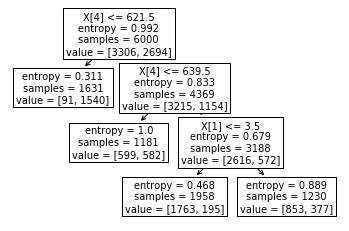

In [43]:
tree.plot_tree(clf)

In [ ]:
dot_data = tree.export_graphviz(
    clf,
    out_file = None, 
    feature_names = X.columns,  
    class_names = ["Intact", "Losses"],  
    filled = True,
    rounded = True,  
    special_characters = True,
)  
graph = graphviz.Source(dot_data) 
graph.render("cart")

### Regression.

In [24]:
def regress(
    name                   ,
    model                  ,
    X_train = X_train      ,
    y_train = y_train      ,
    X_test  = X_test       ,
    y_test  = y_test       ,
    trials  = trials       ,
    metric  = "Unserved MW",
    verbose = False        ,
):
    results = None
    for trial in trials:
        if verbose:
            print(trial)
        fit = model.fit(X_train[trial], y_train[metric])
        score = fit.score(X_test[trial], y_test[metric])
        results = pd.DataFrame({
            "Model"           : [name]                                         ,
            "Weighting"       : re.sub(r" .*$", "", trial[0])                  ,
            "Devices"         : any(["Involves" in factor for factor in trial]),
            "Loss"            : any(["Loss"     in factor for factor in trial]),
            "Radius"          : "Radius"          in trial                     ,
            "Fraction"        : "Fraction"        in trial                     ,
            "Outage Fraction" : "Outage Fraction" in trial                     ,
            "Score"           : score                                          ,
        }).append(results)
    return results.reset_index(drop = True)

#### OLS.

In [25]:
regress_ols = regress(
    "OLS",
    LinearRegression(
    ),
)
regress_ols

,Model,Weighting,Devices,Loss,Radius,Fraction,Outage Fraction,Score
0,OLS,Residue,True,True,True,True,True,0.680331
1,OLS,Residue,True,False,True,True,True,0.668329
2,OLS,Reactance,True,True,True,True,True,0.713868
3,OLS,Reactance,True,False,True,True,True,0.672036
4,OLS,Capacity,True,True,True,True,True,0.686355
...,...,...,...,...,...,...,...,...
75,OLS,Capacity,False,False,False,False,False,0.518146
76,OLS,Reactance,False,True,False,False,False,0.541255
77,OLS,Reactance,False,False,False,False,False,0.518214
78,OLS,Unweighted,False,True,False,False,False,0.640146


In [26]:
regress_ols.Score.max()

0.7138677420832626

#### ANN.

In [27]:
regress_ann = regress(
    "ANN",
    MLPRegressor(
        max_iter = 2500,
    ),
    verbose = True,
)
regress_ann

['Unweighted Betti 0', 'Unweighted Betti 1', 'Unweighted Bottleneck 0 atan', 'Unweighted Bottleneck 1 atan']
['Unweighted Loss', 'Unweighted Betti 0', 'Unweighted Betti 1', 'Unweighted Bottleneck 0 atan', 'Unweighted Bottleneck 1 atan']
['Reactance Betti 0', 'Reactance Betti 1', 'Reactance Bottleneck 0 atan', 'Reactance Bottleneck 1 atan']
['Reactance Loss pu', 'Reactance Betti 0', 'Reactance Betti 1', 'Reactance Bottleneck 0 atan', 'Reactance Bottleneck 1 atan']
['Capacity Betti 0', 'Capacity Betti 1', 'Capacity Bottleneck 0 atan', 'Capacity Bottleneck 1 atan']
['Capacity Loss MW', 'Capacity Betti 0', 'Capacity Betti 1', 'Capacity Bottleneck 0 atan', 'Capacity Bottleneck 1 atan']
['Reactance Betti 0', 'Reactance Betti 1', 'Reactance Bottleneck 0 atan', 'Reactance Bottleneck 1 atan']
['Reactance Loss pu', 'Reactance Betti 0', 'Reactance Betti 1', 'Reactance Bottleneck 0 atan', 'Reactance Bottleneck 1 atan']
['Residue Betti 0', 'Residue Betti 1', 'Residue Bottleneck 0 atan', 'Residue Bo

['Residue Betti 0', 'Residue Betti 1', 'Residue Bottleneck 0 atan', 'Residue Bottleneck 1 atan', 'Involves Line', 'Involves Transformer', 'Radius', 'Fraction']
['Residue Loss MW', 'Residue Betti 0', 'Residue Betti 1', 'Residue Bottleneck 0 atan', 'Residue Bottleneck 1 atan', 'Involves Line', 'Involves Transformer', 'Radius', 'Fraction']
['Unweighted Betti 0', 'Unweighted Betti 1', 'Unweighted Bottleneck 0 atan', 'Unweighted Bottleneck 1 atan', 'Involves Line', 'Involves Transformer', 'Outage Fraction']
['Unweighted Loss', 'Unweighted Betti 0', 'Unweighted Betti 1', 'Unweighted Bottleneck 0 atan', 'Unweighted Bottleneck 1 atan', 'Involves Line', 'Involves Transformer', 'Outage Fraction']
['Reactance Betti 0', 'Reactance Betti 1', 'Reactance Bottleneck 0 atan', 'Reactance Bottleneck 1 atan', 'Involves Line', 'Involves Transformer', 'Outage Fraction']
['Reactance Loss pu', 'Reactance Betti 0', 'Reactance Betti 1', 'Reactance Bottleneck 0 atan', 'Reactance Bottleneck 1 atan', 'Involves Lin

,Model,Weighting,Devices,Loss,Radius,Fraction,Outage Fraction,Score
0,ANN,Residue,True,True,True,True,True,0.861031
1,ANN,Residue,True,False,True,True,True,0.795125
2,ANN,Reactance,True,True,True,True,True,0.870645
3,ANN,Reactance,True,False,True,True,True,0.825152
4,ANN,Capacity,True,True,True,True,True,0.866146
...,...,...,...,...,...,...,...,...
75,ANN,Capacity,False,False,False,False,False,0.529049
76,ANN,Reactance,False,True,False,False,False,0.553643
77,ANN,Reactance,False,False,False,False,False,0.545185
78,ANN,Unweighted,False,True,False,False,False,0.673455


In [28]:
regress_ann.Score.max()

0.8727444163171423

In [29]:
all_regress = pd.concat([
    regress_ann,
    regress_ols,
]).reset_index(drop=True).set_index([
    "Weighting"      ,
    "Devices"        ,
    "Loss"           ,
    "Radius"         ,
    "Fraction"       ,
    "Outage Fraction",
    "Model"          ,
]).sort_index()
all_regress.to_csv("all_regress.tsv", sep = "\t")
all_regress.shape

(160, 1)

In [30]:
all_regress.Score.max()

0.8727444163171423

In [31]:
with pd.option_context("display.max_rows", 1000):
    display(all_regress)

Score
Weighting  Devices Loss  Radius Fraction Outage Fraction Model          
Capacity   False   False False  False    False           ANN    0.529049
                                                         OLS    0.518146
                                         True            ANN    0.655669
                                                         OLS    0.644647
                         True   True     False           ANN    0.829729
                                                         OLS    0.566008
                                         True            ANN    0.841515
                                                         OLS    0.670176
                   True  False  False    False           ANN    0.609278
                                                         OLS    0.575089
                                         True            ANN    0.694648
                                                         OLS    0.667278
                         True   True     False           ANN    0.815408
                                                         OLS    0.605512
                                         True            ANN    0.862847
                                                         OLS    0.685633
           True    False False  False    False           ANN    0.544806
                                                         OLS    0.519226
                                         True            ANN    0.664181
                                                         OLS    0.645643
                         True   True     False           ANN    0.800367
                                                         OLS    0.567372
                                         True            ANN    0.857168
                                                         OLS    0.672058
                   True  False  False    False           ANN    0.624337
                                                         OLS    0.577199
                                         True            ANN    0.706817
                                                         OLS    0.668422
                         True   True     False           ANN    0.825780
                                                         OLS    0.605743
                                         True            ANN    0.866146
                                                         OLS    0.686355
Reactance  False   False False  False    False           ANN    0.511387
                                                         ANN    0.545185
                                                         OLS    0.518214
                                                         OLS    0.518214
                                         True            ANN    0.676467
                                                         ANN    0.669566
                                                         OLS    0.644667
                                                         OLS    0.644667
                         True   True     False           ANN    0.823670
                                                         ANN    0.828794
                                                         OLS    0.566020
                                                         OLS    0.566020
                                         True            ANN    0.859568
                                                         ANN    0.837283
                                                         OLS    0.670157
                                                         OLS    0.670157
                   True  False  False    False           ANN    0.582388
                                                         ANN    0.553643
                                                         OLS    0.541255
                                                         OLS    0.541255
                                         True            ANN    0.784587
                                                    

### Visualize residuals for ANN.

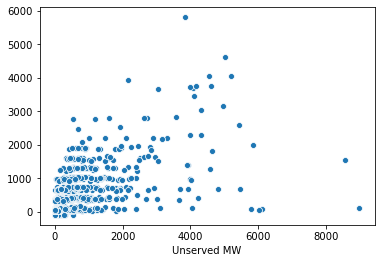

In [30]:
sb.scatterplot(
    x = y_test["Unserved MW"],
    y = reg.predict(X_test[trials[2]])
)